# ECON 5140: Applied Econometrics
## Lesson 2: Time Series Foundations & Decomposition

This notebook demonstrates time series fundamentals using real economic data.

**Topics covered:**
1. Time series structure and indexing
2. Visualization (time plots, ACF)
3. Time series decomposition (additive vs multiplicative)
4. STL decomposition


In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For downloading real economic data
try:
    import yfinance as yf  # For stock market data (install with: pip install yfinance)
    YFINANCE_AVAILABLE = True
except ImportError:
    YFINANCE_AVAILABLE = False
    print("Note: yfinance not available. Will use synthetic data as fallback.")
    print("To install yfinance: pip install yfinance")

try:
    import pandas_datareader.data as web  # For FRED data
    FRED_AVAILABLE = True
except ImportError:
    FRED_AVAILABLE = False
    print("Note: pandas_datareader not available. Will use synthetic data as fallback.")
    print("To install: pip install pandas-datareader")

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)


## Part 1: Time Series Structure and Indexing

**Key concepts:**
- Time index: defines when observations occur
- Frequency: daily, weekly, monthly, quarterly, etc.
- Regularity: evenly spaced vs irregular
- The index controls lag operations, rolling windows, and resampling


### Example 1: Daily Stock Price Data


In [17]:
# Example 1: Download daily stock price data (AAPL - Apple Inc.)
# Daily data from 2020 to 2024
print("Downloading daily stock price data...")

if YFINANCE_AVAILABLE:
    try:
        ticker = yf.Ticker("AAPL")
        stock_data = ticker.history(start="2020-01-01", end="2024-12-31")
        daily_prices = stock_data['Close'].copy()
        print("Successfully downloaded AAPL stock data from Yahoo Finance")
    except Exception as e:
        print(f"Error downloading from yfinance: {e}")
        print("Creating synthetic stock price data...")
        YFINANCE_AVAILABLE = False

if not YFINANCE_AVAILABLE:
    # Create realistic synthetic daily stock price data
    print("Creating synthetic daily stock price data...")
    dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='B')  # Business days
    # Generate realistic stock price with trend, volatility, and some correlation
    n = len(dates)
    returns = np.random.normal(0.0005, 0.02, n)  # Daily returns ~0.05% mean, 2% std
    # Add some autocorrelation and trend
    trend = np.linspace(100, 180, n)
    cumulative_returns = np.cumsum(returns)
    daily_prices = pd.Series(trend * (1 + cumulative_returns * 0.1), index=dates)
    daily_prices = daily_prices.clip(lower=50)  # Ensure positive prices
    print("Created synthetic stock price data")

print(f"\nDaily Stock Price Data:")
print(f"Frequency: Daily")
print(f"Date range: {daily_prices.index.min()} to {daily_prices.index.max()}")
print(f"Number of observations: {len(daily_prices)}")
print(f"\nFirst few observations:")
print(daily_prices.head(10))
print(f"\nData type of index: {type(daily_prices.index)}")
print(f"Index is DatetimeIndex: {isinstance(daily_prices.index, pd.DatetimeIndex)}")


Successfully downloaded AAPL stock data from Yahoo Finance

Daily Stock Price Data:
Frequency: Daily
Date range: 2020-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Number of observations: 1257

First few observations:
Date
2020-01-02 00:00:00-05:00    72.468269
2020-01-03 00:00:00-05:00    71.763718
2020-01-06 00:00:00-05:00    72.335541
2020-01-07 00:00:00-05:00    71.995369
2020-01-08 00:00:00-05:00    73.153511
2020-01-09 00:00:00-05:00    74.707329
2020-01-10 00:00:00-05:00    74.876228
2020-01-13 00:00:00-05:00    76.475899
2020-01-14 00:00:00-05:00    75.443237
2020-01-15 00:00:00-05:00    75.119926
Name: Close, dtype: float64

Data type of index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index is DatetimeIndex: True


In [18]:
# Demonstrate time index operations
print("Time Index Operations:")
print("=" * 60)

# Lag operation (shift)
print("\n1. Lag operation (shift by 1 day):")
lagged = daily_prices.shift(1)
print(f"Original: {daily_prices.iloc[5]:.2f}")
print(f"Lagged:   {lagged.iloc[5]:.2f} (value from previous day)")

# Rolling window
print("\n2. Rolling window (30-day moving average):")
rolling_mean = daily_prices.rolling(window=30).mean()
print(f"30-day MA on {daily_prices.index[50]}: {rolling_mean.iloc[50]:.2f}")

# Resampling (daily to monthly)
print("\n3. Resampling (daily to monthly average):")
monthly_prices = daily_prices.resample('M').mean()
print(f"Monthly data points: {len(monthly_prices)}")
print(f"First monthly value: {monthly_prices.iloc[0]:.2f} on {monthly_prices.index[0]}")

# These operations are only possible with a proper time index!


Time Index Operations:

1. Lag operation (shift by 1 day):
Original: 74.71
Lagged:   73.15 (value from previous day)

2. Rolling window (30-day moving average):
30-day MA on 2020-03-16 00:00:00-04:00: 72.39

3. Resampling (daily to monthly average):
Monthly data points: 60
First monthly value: 75.26 on 2020-01-31 00:00:00-05:00


### Example 2: Monthly Economic Data - US Exports


In [19]:
# Example 2: Monthly economic data - US Exports
# Using FRED (Federal Reserve Economic Data) via pandas_datareader
print("Downloading monthly US exports data from FRED...")

if FRED_AVAILABLE:
    try:
        # US Exports of Goods and Services (monthly, seasonally adjusted)
        # FRED series code: EXPGS
        exports = web.DataReader('EXPGS', 'fred', start='2010-01-01', end='2024-12-31')
        exports_monthly = exports['EXPGS'].dropna()
        print("Successfully downloaded US exports data from FRED")
    except Exception as e:
        print(f"Error downloading FRED data: {e}")
        print("Using synthetic monthly export data for demonstration...")
        FRED_AVAILABLE = False

if not FRED_AVAILABLE:
    # Create synthetic monthly export data if FRED is unavailable
    print("Creating synthetic monthly export data...")
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='M')
    trend = np.linspace(200, 350, len(dates))
    seasonal = 20 * np.sin(2 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 5, len(dates))
    exports_monthly = pd.Series(trend + seasonal + noise, index=dates)
    exports_monthly = exports_monthly.clip(lower=150)
    print(f"Created synthetic monthly export data with {len(exports_monthly)} observations")

print(f"\nMonthly US Exports Data:")
print(f"Frequency: Monthly")
print(f"Date range: {exports_monthly.index.min()} to {exports_monthly.index.max()}")
print(f"Number of observations: {len(exports_monthly)}")
print(f"\nFirst few observations:")
print(exports_monthly.head(10))
print(f"\nUnits: Billions of Dollars (seasonally adjusted)")


Successfully downloaded US exports data from FRED

Monthly US Exports Data:
Frequency: Monthly
Date range: 2010-01-01 00:00:00 to 2024-10-01 00:00:00
Number of observations: 60

First few observations:
DATE
2010-01-01    1759.877
2010-04-01    1819.741
2010-07-01    1877.253
2010-10-01    1972.116
2011-01-01    2040.407
2011-04-01    2116.132
2011-07-01    2156.793
2011-10-01    2150.123
2012-01-01    2189.981
2012-04-01    2215.586
Name: EXPGS, dtype: float64

Units: Billions of Dollars (seasonally adjusted)


## Part 2: Visualization - The Foundation of Time Series Analysis

**Key visualizations:**
- Time plot: shows trends, level shifts, outliers
- ACF plot: shows temporal dependence and autocorrelation

Visualization is essential before modeling - it reveals patterns that guide model selection.


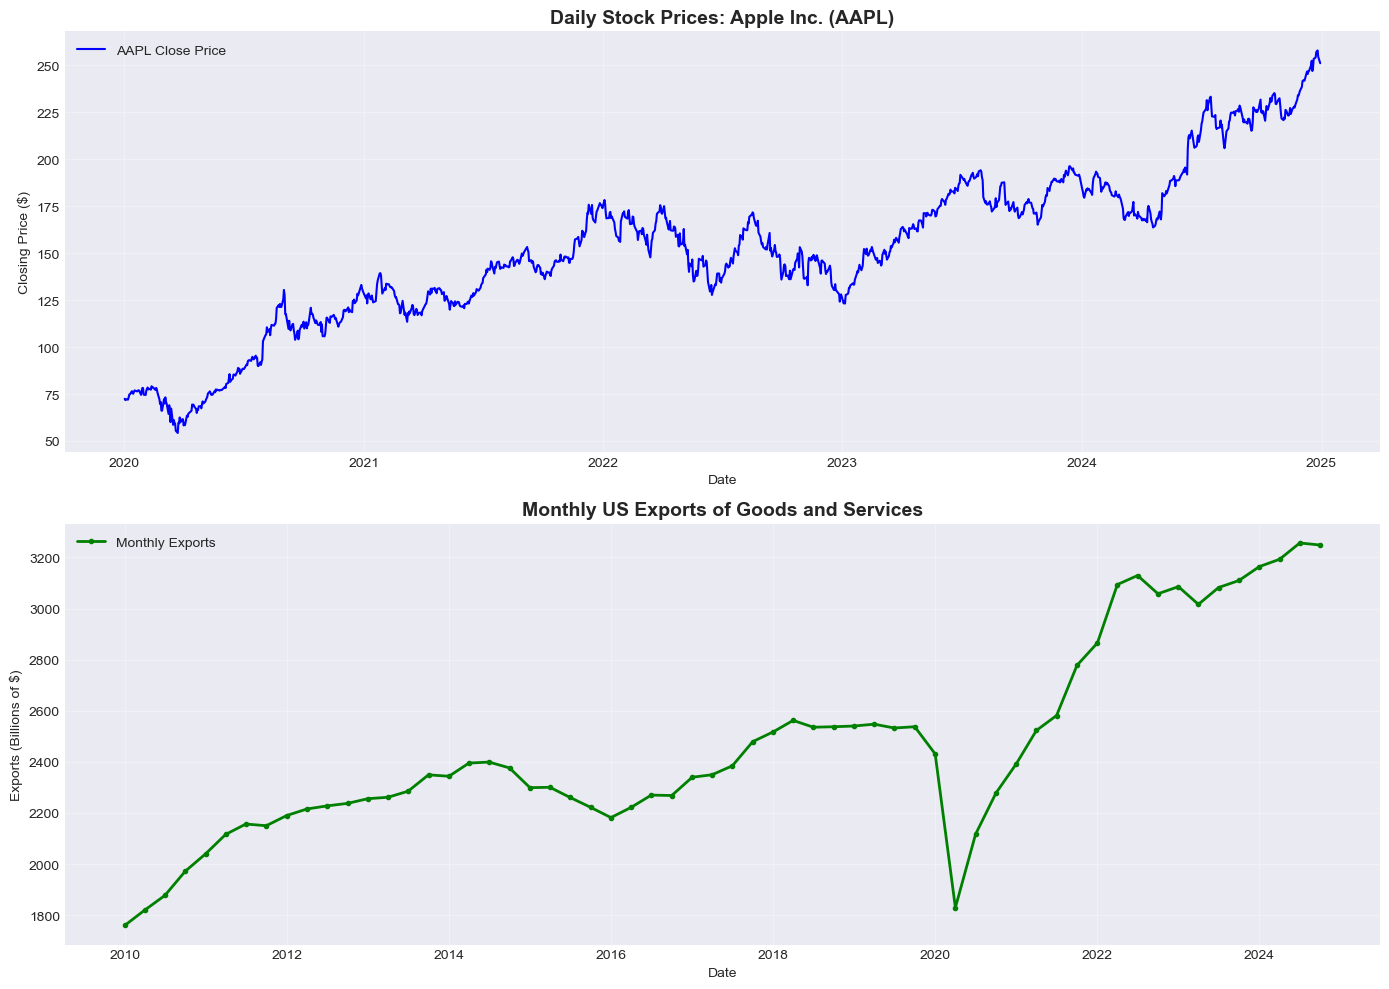

Key observations from time plots:
1. Daily stock prices: Volatile, trending upward, potential structural breaks
2. Monthly exports: Clear seasonal patterns, overall growth trend


In [20]:
# Time plot for daily stock prices
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Daily stock prices
axes[0].plot(daily_prices.index, daily_prices.values, linewidth=1.5, color='blue')
axes[0].set_title('Daily Stock Prices: Apple Inc. (AAPL)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price ($)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(['AAPL Close Price'], loc='upper left')

# Monthly exports
axes[1].plot(exports_monthly.index, exports_monthly.values, linewidth=2, color='green', marker='o', markersize=3)
axes[1].set_title('Monthly US Exports of Goods and Services', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Exports (Billions of $)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(['Monthly Exports'], loc='upper left')

plt.tight_layout()
plt.show()

print("Key observations from time plots:")
print("1. Daily stock prices: Volatile, trending upward, potential structural breaks")
print("2. Monthly exports: Clear seasonal patterns, overall growth trend")


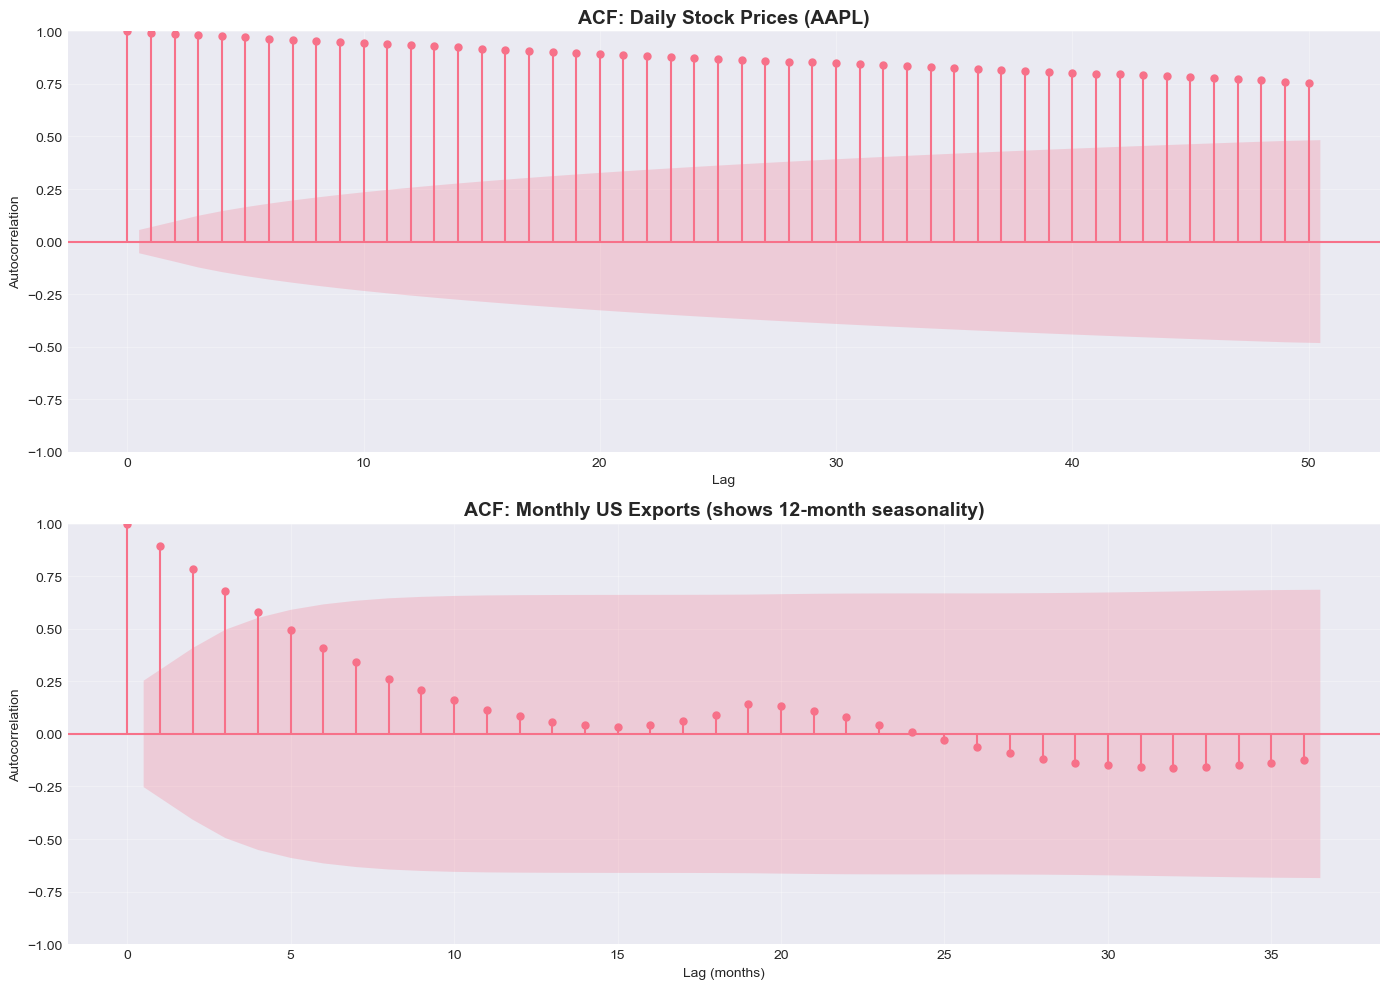

Interpreting ACF plots:
1. Daily stock prices: Slow decay suggests strong persistence/trend
2. Monthly exports: Spikes at lags 12, 24, 36 indicate yearly seasonality


In [21]:
# Autocorrelation Function (ACF) plots
# ACF shows how observations are correlated with past observations

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ACF for daily stock prices (first 50 lags)
plot_acf(daily_prices.dropna(), lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: Daily Stock Prices (AAPL)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

# ACF for monthly exports (first 36 lags to show yearly seasonality)
plot_acf(exports_monthly.dropna(), lags=36, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF: Monthly US Exports (shows 12-month seasonality)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (months)')
axes[1].set_ylabel('Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpreting ACF plots:")
print("1. Daily stock prices: Slow decay suggests strong persistence/trend")
print("2. Monthly exports: Spikes at lags 12, 24, 36 indicate yearly seasonality")


## Part 3: Time Series Decomposition

**Decomposition separates a time series into:**
- **Trend (T)**: Long-run movements
- **Seasonality (S)**: Repeating patterns
- **Remainder (R)**: Irregular/random component

**Two main forms:**
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (seasonal amplitude grows with level)


Performing additive decomposition on monthly exports...


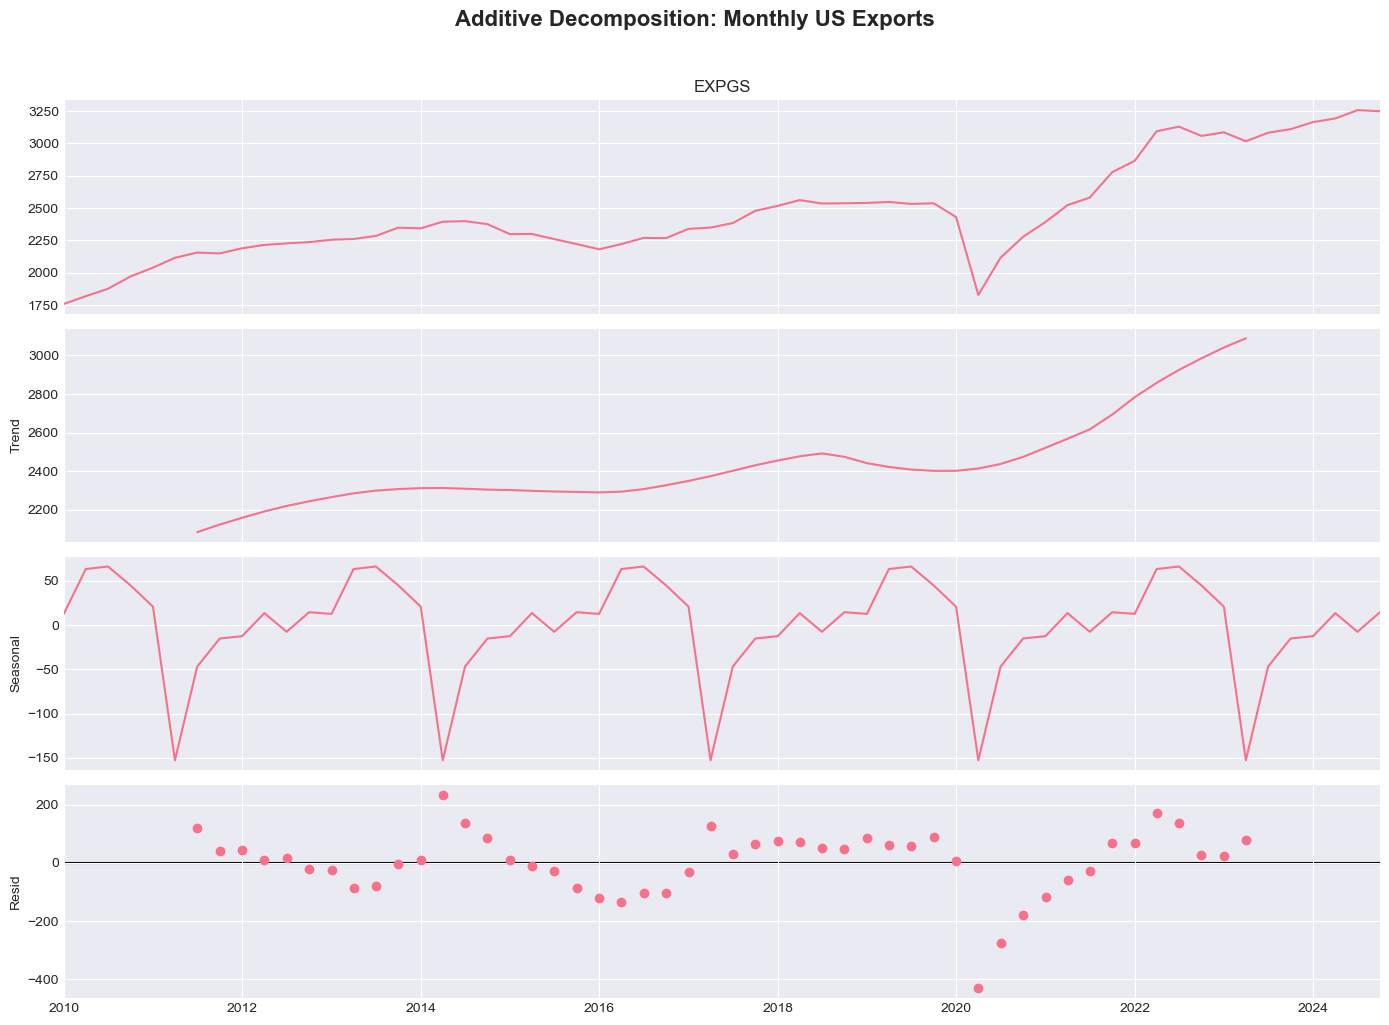


Additive decomposition assumes: Y_t = Trend + Seasonal + Remainder
Trend range: 2084.27 to 3088.78
Seasonal range: -152.81 to 66.12
Remainder std: 114.41


In [22]:
# Classical decomposition - Additive
# For monthly data, we use period=12 for yearly seasonality
print("Performing additive decomposition on monthly exports...")
decomp_additive = seasonal_decompose(exports_monthly.dropna(), model='additive', period=12)

# Plot the decomposition
fig = decomp_additive.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Additive Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAdditive decomposition assumes: Y_t = Trend + Seasonal + Remainder")
print(f"Trend range: {decomp_additive.trend.min():.2f} to {decomp_additive.trend.max():.2f}")
print(f"Seasonal range: {decomp_additive.seasonal.min():.2f} to {decomp_additive.seasonal.max():.2f}")
print(f"Remainder std: {decomp_additive.resid.std():.2f}")


Performing multiplicative decomposition on monthly exports...


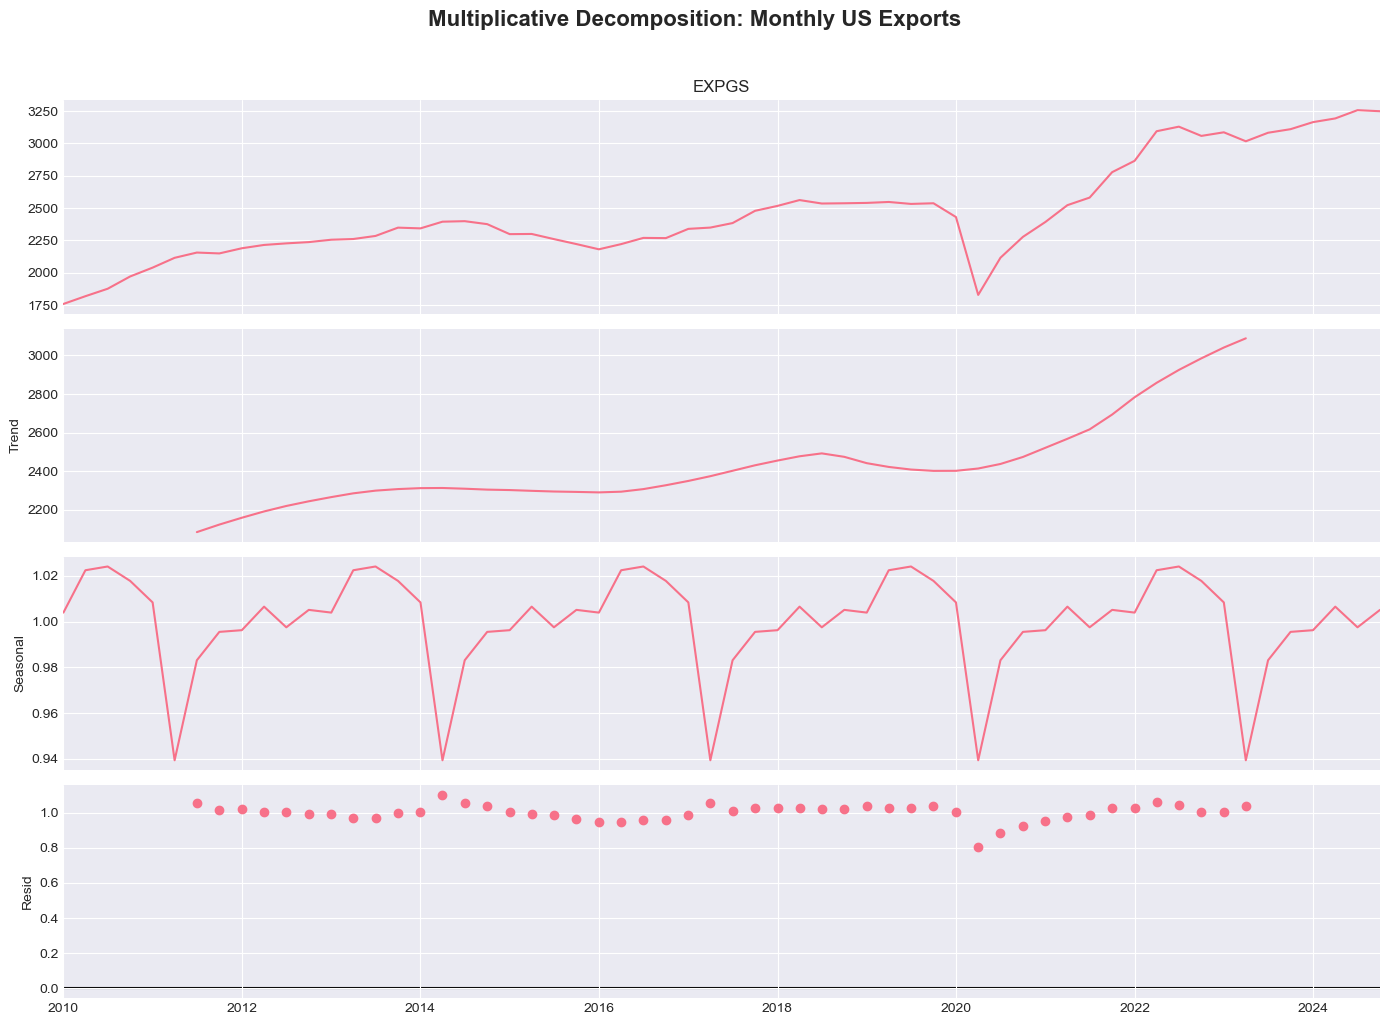


Multiplicative decomposition assumes: Y_t = Trend × Seasonal × Remainder
Trend range: 2084.27 to 3088.78
Seasonal range: 0.939 to 1.024
Remainder std: 0.0481


In [23]:
# Classical decomposition - Multiplicative
# Multiplicative is appropriate when seasonal variation grows with the level
print("Performing multiplicative decomposition on monthly exports...")
decomp_multiplicative = seasonal_decompose(exports_monthly.dropna(), model='multiplicative', period=12)

# Plot the decomposition
fig = decomp_multiplicative.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Multiplicative Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nMultiplicative decomposition assumes: Y_t = Trend × Seasonal × Remainder")
print(f"Trend range: {decomp_multiplicative.trend.min():.2f} to {decomp_multiplicative.trend.max():.2f}")
print(f"Seasonal range: {decomp_multiplicative.seasonal.min():.3f} to {decomp_multiplicative.seasonal.max():.3f}")
print(f"Remainder std: {decomp_multiplicative.resid.std():.4f}")


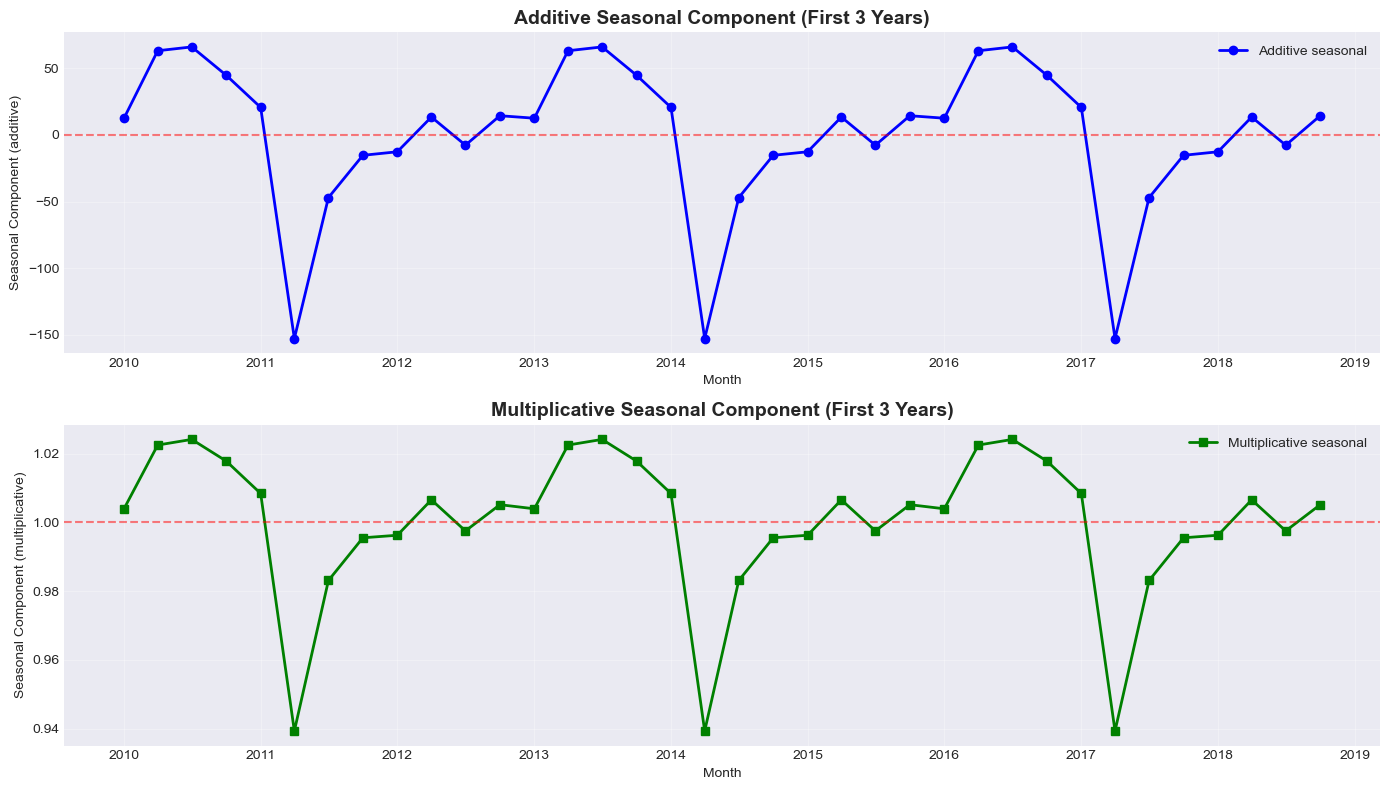

Key difference:
- Additive: Seasonal component adds/subtracts a fixed amount (centered around 0)
- Multiplicative: Seasonal component multiplies by a factor (centered around 1.0)
- Choose multiplicative when seasonal amplitude grows with the level of the series


In [24]:
# Compare additive vs multiplicative seasonal components
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot first 36 months to see seasonal pattern clearly
months_to_plot = 36

# Additive seasonal component
axes[0].plot(decomp_additive.seasonal.iloc[:months_to_plot], 
             marker='o', linewidth=2, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Additive Seasonal Component (First 3 Years)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Seasonal Component (additive)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(['Additive seasonal'], loc='upper right')

# Multiplicative seasonal component
axes[1].plot(decomp_multiplicative.seasonal.iloc[:months_to_plot], 
             marker='s', linewidth=2, color='green')
axes[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Multiplicative Seasonal Component (First 3 Years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Seasonal Component (multiplicative)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(['Multiplicative seasonal'], loc='upper right')

plt.tight_layout()
plt.show()

print("Key difference:")
print("- Additive: Seasonal component adds/subtracts a fixed amount (centered around 0)")
print("- Multiplicative: Seasonal component multiplies by a factor (centered around 1.0)")
print("- Choose multiplicative when seasonal amplitude grows with the level of the series")


### STL Decomposition: A Modern Alternative

**STL (Seasonal–Trend decomposition using Loess)** is preferred over classical decomposition because:

1. **Handles changing seasonal patterns**: Seasonality can evolve over time
2. **Robust to outliers**: Less sensitive to extreme observations
3. **Flexible**: Works with any seasonal frequency
4. **Local estimation**: Uses nearby observations, not the entire dataset

**Key insight**: STL estimates trend and seasonality locally in time, allowing patterns to change gradually.


Performing STL decomposition on monthly exports...


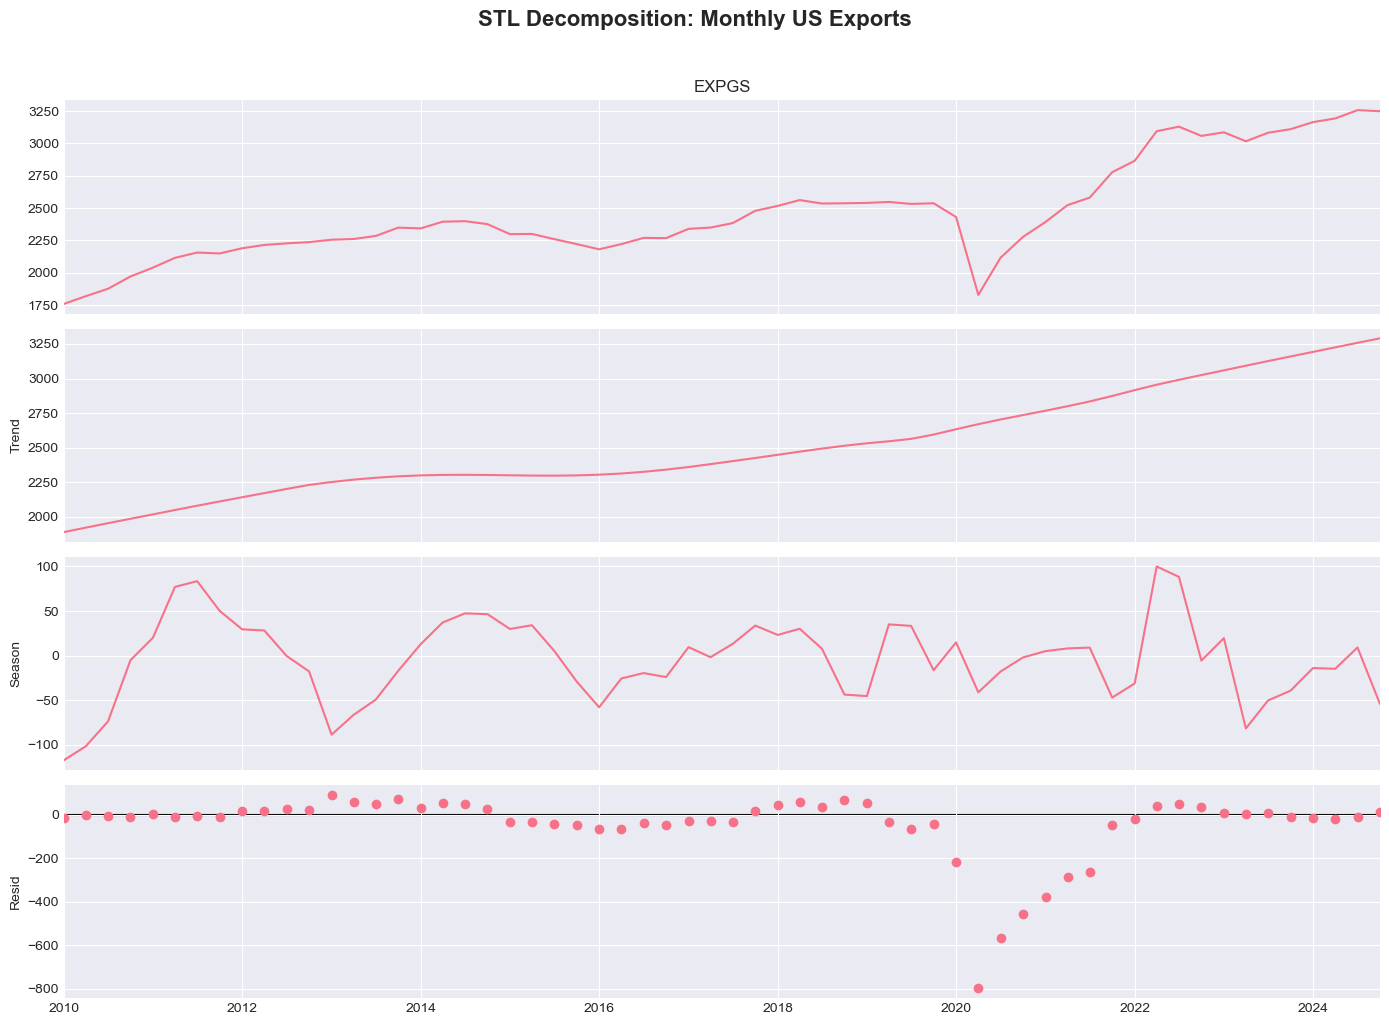


STL decomposition components:
Trend range: 1889.88 to 3290.57
Seasonal range: -117.66 to 99.99
Remainder std: 157.51


In [25]:
# STL Decomposition
# STL is more flexible and robust than classical decomposition
print("Performing STL decomposition on monthly exports...")
stl = STL(exports_monthly.dropna(), period=12, robust=True)
stl_result = stl.fit()

# Plot STL decomposition
fig = stl_result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('STL Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nSTL decomposition components:")
print(f"Trend range: {stl_result.trend.min():.2f} to {stl_result.trend.max():.2f}")
print(f"Seasonal range: {stl_result.seasonal.min():.2f} to {stl_result.seasonal.max():.2f}")
print(f"Remainder std: {stl_result.resid.std():.2f}")


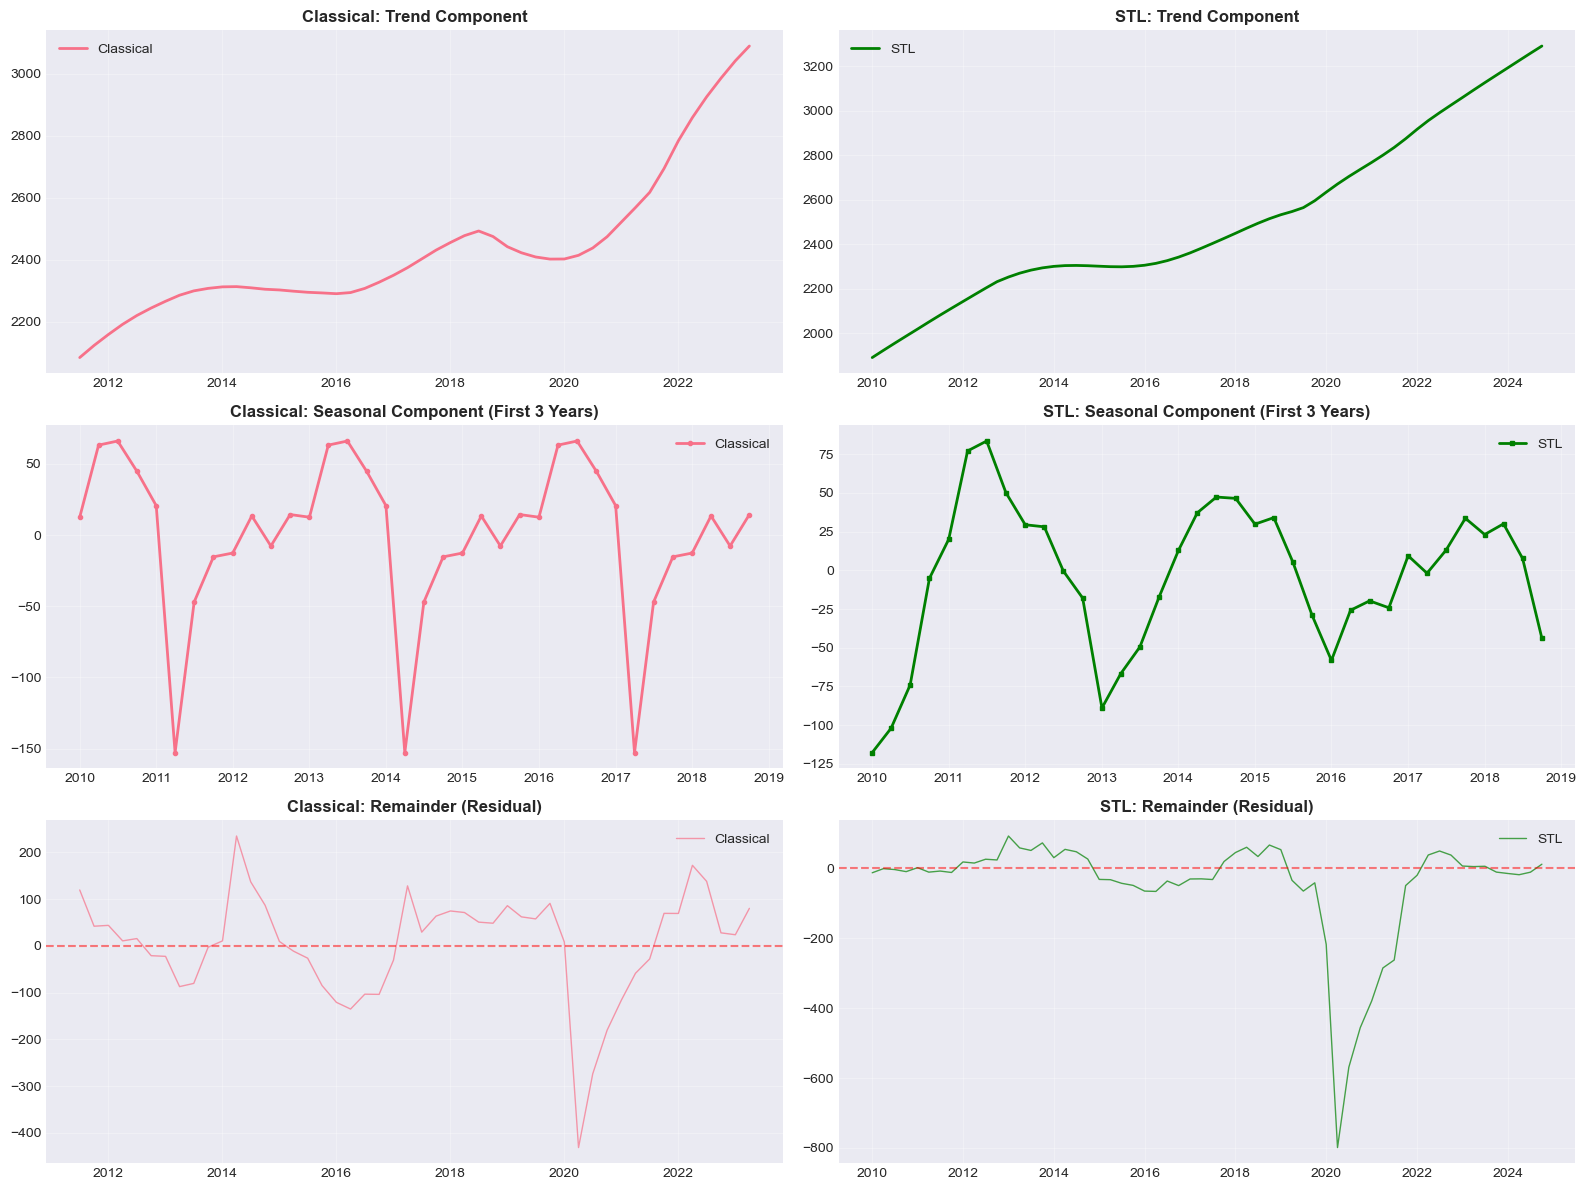

Key differences:
1. STL trend is smoother and more flexible
2. STL seasonal component can change over time (not shown in first 3 years)
3. STL remainder typically has smaller variance (better separation)


In [26]:
# Compare Classical vs STL decomposition
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Trend comparison
axes[0, 0].plot(exports_monthly.index, decomp_additive.trend, label='Classical', linewidth=2)
axes[0, 0].set_title('Classical: Trend Component', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(exports_monthly.index, stl_result.trend, label='STL', linewidth=2, color='green')
axes[0, 1].set_title('STL: Trend Component', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Seasonal comparison (first 3 years)
axes[1, 0].plot(decomp_additive.seasonal.iloc[:36], label='Classical', linewidth=2, marker='o', markersize=3)
axes[1, 0].set_title('Classical: Seasonal Component (First 3 Years)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(stl_result.seasonal.iloc[:36], label='STL', linewidth=2, color='green', marker='s', markersize=3)
axes[1, 1].set_title('STL: Seasonal Component (First 3 Years)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# Remainder comparison
axes[2, 0].plot(exports_monthly.index, decomp_additive.resid, label='Classical', linewidth=1, alpha=0.7)
axes[2, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2, 0].set_title('Classical: Remainder (Residual)', fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].legend()

axes[2, 1].plot(exports_monthly.index, stl_result.resid, label='STL', linewidth=1, color='green', alpha=0.7)
axes[2, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2, 1].set_title('STL: Remainder (Residual)', fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].legend()

plt.tight_layout()
plt.show()

print("Key differences:")
print("1. STL trend is smoother and more flexible")
print("2. STL seasonal component can change over time (not shown in first 3 years)")
print("3. STL remainder typically has smaller variance (better separation)")


## Part 4: Decomposition for Daily Data (Stock Prices)

Daily stock prices don't have monthly/yearly seasonality, but they do have:
- Trends (long-run movements)
- Weekly patterns (lower volume on Fridays)
- Irregular fluctuations (market shocks)

Let's apply decomposition to understand the structure.


Performing STL decomposition on daily stock prices...
Using period=252 to capture potential yearly patterns


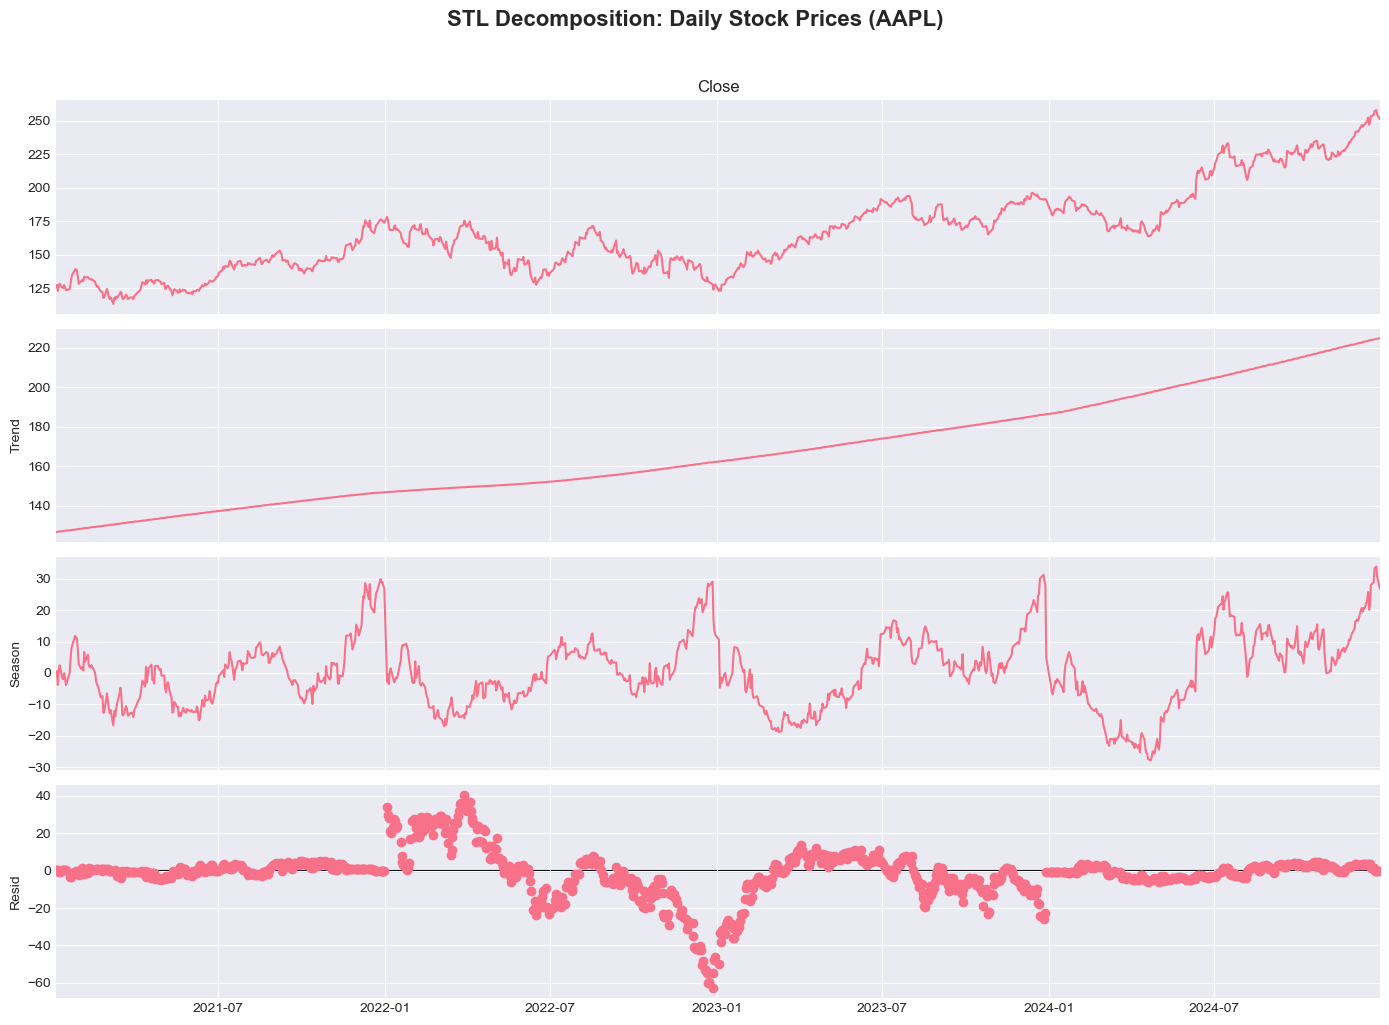


Stock price decomposition insights:
1. Trend: Captures long-term growth/decline
2. Seasonal: Yearly patterns (if any)
3. Remainder: Daily fluctuations and market shocks

Remainder standard deviation: $12.44
This represents the daily volatility after removing trend and seasonality


In [27]:
# For daily stock prices, we might look for weekly patterns (period=5 for business days)
# But stock prices are better modeled with trend + remainder (no strong seasonality)
# Let's use a longer period to capture longer-term patterns

# Use period=252 for yearly pattern in trading days (approximately 252 trading days per year)
print("Performing STL decomposition on daily stock prices...")
print("Using period=252 to capture potential yearly patterns")

# Use a subset of data for cleaner visualization
stock_subset = daily_prices['2021-01-01':'2024-12-31'].dropna()

stl_stock = STL(stock_subset, period=252, robust=True)
stl_stock_result = stl_stock.fit()

# Plot STL decomposition
fig = stl_stock_result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('STL Decomposition: Daily Stock Prices (AAPL)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nStock price decomposition insights:")
print("1. Trend: Captures long-term growth/decline")
print("2. Seasonal: Yearly patterns (if any)")
print("3. Remainder: Daily fluctuations and market shocks")
print(f"\nRemainder standard deviation: ${stl_stock_result.resid.std():.2f}")
print("This represents the daily volatility after removing trend and seasonality")


## Summary: What Decomposition Tells Us

**Decomposition helps us:**

1. **Understand structure**: Separates trend, seasonality, and noise
2. **Diagnose patterns**: Identify what needs modeling
3. **Guide model selection**: 
   - Strong seasonality → seasonal models needed
   - Changing trend → flexible trend models
   - Persistent remainder → ARIMA models for dependence

**Important reminder:**

- Decomposition is a **diagnostic tool**, not a forecasting model
- It reveals structure but doesn't predict the future
- Use decomposition to inform which models to use

**Next steps:**

- **Lesson 3**: ETS models (exponential smoothing) - model trend and seasonality directly
- **Lesson 4**: ARIMA models - model dependence in the remainder


## Key Takeaways

### Time Series Structure
- The time index is essential - it enables lag operations, rolling windows, and resampling
- Frequency matters (daily, monthly, etc.) - determines possible seasonality
- Always use proper time indexing in pandas

### Visualization
- **Time plots**: Reveal trends, level shifts, outliers
- **ACF plots**: Show temporal dependence and autocorrelation patterns
- Always visualize before modeling

### Decomposition
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (seasonal amplitude grows with level)
- **STL**: Preferred method - handles changing patterns, robust to outliers

### Choosing the Right Method
- Constant seasonal size → Additive
- Proportional seasonal size → Multiplicative (or log-transform)
- Need robustness/flexibility → STL


## References

- ECON 5140: Applied Econometrics, Lesson 2 - Time Series Foundations & Decomposition
- Statsmodels documentation: https://www.statsmodels.org/
- Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: principles and practice* (3rd ed.). Available at https://otexts.com/fpp3/
- FRED Economic Data: https://fred.stlouisfed.org/
- yfinance: https://pypi.org/project/yfinance/
